In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

# Language modeling

## Grabbing data for the model

In [3]:
PATH = 'data/aclImdb/'

TRAIN_PATH = 'train/all/'
VALIDATION_PATH = 'test/all/'
TRAIN = f'{PATH}{TRAIN_PATH}'
VALIDATION = f'{PATH}{TRAIN_PATH}'

% ls {PATH}

imdbEr.txt  imdb.vocab  models/  README  test/  tmp/  train/


In [4]:
training_files = ! ls {TRAIN}
training_files[:10]

['0_0.txt',
 '0_3.txt',
 '0_9.txt',
 '10000_0.txt',
 '10000_4.txt',
 '10000_8.txt',
 '1000_0.txt',
 '10001_0.txt',
 '10001_10.txt',
 '10001_4.txt']

In [5]:
review = ! cat {TRAIN}{training_files[6]}
review[0]

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop-socky fung-ku, but what I got instead was a comedy. So, it wasn't quite was I was expecting, but I really liked it anyway! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them!! I was laughing my ass off. I mean, the cops were just so bad! And when I say bad, I mean The Shield Vic Macky bad. But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose...man, oh man. What can you say about that hottie. She was great and put those other actresses to shame. She should work more often!!!!! I also really liked the fight scene outside of the building. That was done really well. Lots of fighting and people getting their heads banged up. FUN! Last, but not least Joe Estevez and William Smith were great as the...well, I wasn't sure what they were, but they seemed to be having fun and throwing out 

In [6]:
# not sure why this is giving me the wrong answer, or at least different from command-line version
# ! find {TRAIN} -name '*.txt' | xargs wc -w | tail

In [6]:
! find {TRAIN} -name '*.txt' | xargs cat | wc -w

17486581


In [9]:
spacy_tokens = spacy.load('en_core_web_sm')

In [9]:
' '.join([token.string.strip() for token in spacy_tokens(review[0])])

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop - socky fung - ku , but what I got instead was a comedy . So , it was n't quite was I was expecting , but I really liked it anyway ! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them ! ! I was laughing my ass off . I mean , the cops were just so bad ! And when I say bad , I mean The Shield Vic Macky bad . But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose ... man , oh man . What can you say about that hottie . She was great and put those other actresses to shame . She should work more often ! ! ! ! ! I also really liked the fight scene outside of the building . That was done really well . Lots of fighting and people getting their heads banged up . FUN ! Last , but not least Joe Estevez and William Smith were great as the ... well , I was n't sure what they were , but they see

## Creating a model

In [15]:
# If you haven't dumped yet
# TEXT = data.Field(lower=True, tokenize="spacy")

# If you have a TEXT dump already
# TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl', 'rb'))

In [16]:
bs = 64
bptt = 70

In [17]:
FILES = dict(train=TRAIN_PATH, validation=VALIDATION_PATH, test=VALIDATION_PATH)

In [20]:
model = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [52]:
# If you haven't dumped yet
# pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

## Analysis of model

In [21]:
{
    'batches': len(model.trn_dl),
    'unique_tokens_in_training_set': model.nt,
    'tokens_in_training_set': len(model.trn_ds),
    'sentences': len(model.trn_ds[0].text)
}

{'batches': 4583,
 'unique_tokens_in_training_set': 37392,
 'tokens_in_training_set': 1,
 'sentences': 20540756}

In [22]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [23]:
TEXT.vocab.stoi['the']

2

In [24]:
model.trn_ds[0].text[:10]

['at', 'first', ',', 'i', 'thought', 'this', 'was', 'a', 'sequel', 'to']

In [25]:
TEXT.numericalize([model.trn_ds[0].text[:10]])

Variable containing:
   40
  102
    3
   12
  213
   13
   19
    6
  701
    8
[torch.cuda.LongTensor of size 10x1 (GPU 0)]

In [26]:
next(iter(model.trn_dl))

(Variable containing:
     40     20     11  ...      20     11   2519
    102      6     16  ...    9324     27      4
      3   8852     31  ...      20      2      8
         ...            ⋱           ...         
    588     53    113  ...      31   1404      2
     30    228    234  ...       6     84    491
      4   8453     68  ...     906      4      7
 [torch.cuda.LongTensor of size 69x64 (GPU 0)], Variable containing:
    102
      6
     16
   ⋮   
   3859
     20
      0
 [torch.cuda.LongTensor of size 4416 (GPU 0)])

## Training

Now we have a base model, need to train it a bit

In [27]:
embedding_vector_size = 200
hidden_activations_per_layer = 500
layers = 3

In [28]:
optim_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [29]:
learner = model.get_model(optim_fn, embedding_vector_size, hidden_activations_per_layer, layers,
                          dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [76]:
learner.lr_find()

AttributeError: 'LR_Finder' object has no attribute 'lr_find'

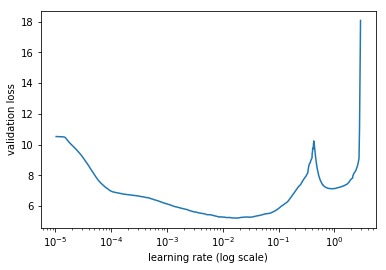

In [75]:
learner.sched.plot()

In [77]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                
    0      4.841983   4.723696  
    1      4.651874   4.529144                                
    2      4.561364   4.444034                                
    3      4.595158   4.47316                                 
    4      4.523873   4.395108                                
    5      4.453586   4.338749                                
    6      4.392676   4.321768                                
    7      4.539115   4.412554                                
    8      4.508717   4.383091                                
  3%|▎         | 124/4583 [00:11<07:07, 10.44it/s, loss=4.47]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    10     4.428735   4.321911                                
    11     4.394844   4.293007                                
  7%|▋         | 322/4583 [00:30<06:41, 10.62it/s, loss=4.37]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    14     4.314586   4.253835                                


[array([4.25384])]

In [80]:
learner.save_encoder('adam1_enc')

In [81]:
learner.load_encoder('adam1_enc')

In [83]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

epoch      trn_loss   val_loss                                
    0      4.492626   4.372111  
    1      4.463509   4.352433                                
    2      4.45674    4.337979                                
    3      4.42845    4.314045                                
    4      4.407136   4.294185                                
    5      4.3635     4.270195                                
    6      4.33184    4.248859                                
    7      4.305493   4.234384                                
    8      4.285512   4.226517                                
    9      4.271184   4.225058                                


[array([4.22506])]

In [84]:
learner.save_encoder('adam3_10_enc')

In [30]:
learner.load_encoder('adam3_10_enc')

In [87]:
math.exp(4.225)

68.3745035485581

In [ ]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl', 'rb'))

In [37]:
m = learner.model
ss = """. So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
#s = [spacy_tokens(ss)]
s = [TEXT.tokenize(ss)]
t = TEXT.numericalize(s)
t

Variable containing:
    4
    0
    3
   11
   19
   29
  198
   19
    0
   19
 1043
    3
   24
    0
   78
  437
   11
  727
   45
    0
  136
[torch.cuda.LongTensor of size 21x1 (GPU 0)]

In [35]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [38]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['of',
 ',',
 'movie',
 'actor',
 'was',
 'scene',
 'friend',
 'thing',
 'film',
 'performance']

In [49]:
print(ss,"\n")
for i in range(100):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite was I was expecting, but I really liked it anyway! The best 

was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting was horrible , the acting ...


## Sentiment

In [50]:
IMDB_LABEL = data.Field(sequential=False)

In [51]:
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

downloading aclImdb_v1.tar.gz


In [53]:
t = splits[0].examples[0]
t.label, ' '.join(t.text[:16])

('pos',
 "fantastic documentary of 1924 . this early 20th century geography of today 's iraq was powerful")

In [54]:
md2 = TextData.from_splits(PATH, splits, bs)

In [55]:
m3 = md2.get_model(optim_fn, 1500, bptt, emb_sz=embedding_vector_size, n_hid=hidden_activations_per_layer,
                   n_layers=layers, dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_10_enc')

In [56]:
m3.clip = 25.
learning_rates = np.array([1e-4, 1e-4, 1e-4, 1e-3, 1e-2])

In [58]:
m3.freeze_to(-1)
m3.fit(learning_rates / 2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(learning_rates, 1, metrics=[accuracy], cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.421371   0.264162   0.890981  



epoch      trn_loss   val_loss   accuracy                    
    0      0.376231   0.242051   0.902744  



[array([0.24205]), 0.902743504051742]

In [59]:
m3.fit(learning_rates, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.361173   0.290338   0.887356  
    1      0.334963   0.229705   0.909139                    
    2      0.326627   0.225653   0.909334                    
    3      0.298526   0.213387   0.917786                    
    4      0.317422   0.210662   0.919679                    
    5      0.297057   0.207692   0.919695                    
    6      0.291962   0.205088   0.923423                    
    7      0.28106    0.198827   0.923242                    
    8      0.279098   0.19605    0.924849                    
    9      0.26288    0.193004   0.926278                    
    10     0.268692   0.192857   0.926454                    
    11     0.284444   0.189978   0.928589                    
    12     0.264829   0.196085   0.925599                    
    13     0.251859   0.192116   0.926881                    



[array([0.19212]), 0.9268813631620508]

In [61]:
m3.load_cycle('imdb2', 4)
accuracy_np(*m3.predict_with_targs())

0.92904

In [62]:
m3.load_cycle('imdb2', 5)
accuracy_np(*m3.predict_with_targs())

0.93128

In [63]:
m3.load_cycle('imdb2', 6)
accuracy_np(*m3.predict_with_targs())

0.93068